#Exercise 1: Convolutional Autoencoder#

Train a convolutional autoencoder on MNIST, study the influence of the bottleneck size and generate some images

In [0]:
import numpy as np
np.random.seed(1)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':2,
    'test_batch_size':64,
    'hidden_size':128,
    'learning_rate':1e-3,
    'log_interval':100,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

**Load Dataset**

In [0]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))                        
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

**Split data**:
We split the data in 95% for training and 5% for validation

In [57]:
#we take the size of the trainset and after that we take 5% of dataset
tvdataset_length = len(mnist_trainset)
validationset_length = int(0.05*tvdataset_length)
#we split the dataset
[trainset,validationset]=torch.utils.data.random_split(mnist_trainset,[tvdataset_length-validationset_length,validationset_length])
print('Validation dataset is :{}%'.format(100*len(validationset)/len(mnist_trainset)))
print('Training dataset is :{}%'.format(100*len(trainset)/len(mnist_trainset)))

Validation dataset is :5.0%
Training dataset is :95.0%


**Loader data**
We load the dataset with batch size 

In [0]:
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    validationset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

## 2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules). ##

**Creation of the Class Autoencoder**

**Define of the Class encoder**

In [0]:
class Encoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.bottleneck = bottleneck
    self.conv1 = nn.Sequential( 
              nn.Conv2d(1,64,5,padding=2),
              nn.MaxPool2d(2,2),
              nn.ReLU(inplace = True),
              nn.Dropout(0.5))
    self.conv2 = nn.Sequential(
              nn.Conv2d(64,32,5,padding=2),
              nn.ReLU(inplace = True),
              nn.Dropout(0.5)
              )
    self.conv3 = nn.Sequential(
              nn.Conv2d(32,16,5,padding=2),
              nn.MaxPool2d(2,2),
              nn.ReLU(inplace = True),
              nn.Dropout(0.5),
              nn.Flatten()
    )
    self.fc = nn.Sequential(
              nn.Linear(16*7*7,self.bottleneck),
              nn.ReLU())
  def forward(self,x):
    x= self.conv1(x)
    x= self.conv2(x)
    x= self.conv3(x)
    x= self.fc(x)
    return x  

**Define of the class Decoder**

In [0]:
class Decoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.bottleneck = bottleneck
    self.conv1 = nn.Sequential( 
          nn.ConvTranspose2d(64,32,14,stride=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Dropout(0.5))
    self.conv2 = nn.Sequential(
          nn.ConvTranspose2d(32,1,2,stride=2),
          nn.Sigmoid())
    self.fc = nn.Sequential(
          nn.Linear(self.bottleneck,64),
          nn.ReLU())
  def forward(self,x):
    x= self.fc(x)
    x= self.conv1(x.view(x.shape[0], 64, 1,1))
    x= self.conv2(x)
    return x

**Define of the class Autoencoder**

In [0]:
class Autoencoder(nn.Module):
    def __init__(self,bottleneck):
      super().__init__()
      self.bottleneck = bottleneck
      self.encoder = Encoder(self.bottleneck)
      self.decoder = Decoder(self.bottleneck)
    def forward(self,x):
      x= self.encoder(x)
      x= self.decoder(x)
      return x

**Train the Model**

Definition of the function *train epoch*. It train the weights of the model. It computes the loss of the train and it performs the backpropagation. 

In [0]:
def train_epoch(train_loader,model,optimizer,criterion,hparams):
  model.train()
  #avg_loss_train = None
  #avg_weight = 0.1
  losses = []
  for batch_idx, data in enumerate(train_loader):
          optimizer.zero_grad()
          img, _ = data
          img = img.cuda()
          output = model(img)
          loss = criterion(output,img)
          loss.backward()
          optimizer.step()
          if batch_idx % hparams['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            #avg_loss_train = loss.item() 
          losses.append(loss.item())
  return losses

It is a generic fonction to evaluate the model it return the loss average and the MSE. 

In [0]:
def test_epoch(set_loader,model,hparams):
  model.eval()
  avg_loss_validation =0
  MSE = 0
  with torch.no_grad():
    for data in set_loader:
      img,_ = data
      img = img.cuda()
      output = model(img)
      val_loss = criterion(output,img)
      MSE += criterion_MSE(output,img)
      avg_loss_validation+= val_loss
  avg_loss_validation /= len(set_loader)
  MSE /= len(set_loader) 
  return avg_loss_validation,MSE

Fuction to compute the number of paramater 

In [0]:
def number_param(model):
  return sum(p.numel() for p in model.parameters())

###Train of the model and evalutation of it with different bottleneck###

In [85]:
dic_MSE = dict()
validation_loss_bottleneck = dict()
train_loss_bottleneck = dict()
models = dict()
for bottleneck in range(5,25,4):
  model = Autoencoder(bottleneck).cuda()
  model.to(hparams['device'])
  models[bottleneck] = model
  print('Bottleneck :{}'.format(bottleneck))
  number_param_bottleneck = number_param(model)
  print('Number param for a bottleneck of {} : {} parameters'.format(bottleneck,number_param_bottleneck))
  list_MSE_validation = []
  train_loss = []
  validation_loss = []
  criterion_MSE = nn.MSELoss()
  criterion = nn.MSELoss()#nn.BCELoss()
  optimizer =  optim.Adam(model.parameters(), lr=hparams['learning_rate'])
  for epoch in range(hparams['num_epochs']):
    train_loss.extend(train_epoch(train_loader,model,optimizer,criterion,hparams))
    val_loss,MSE_validation = test_epoch(validation_loader,model,hparams)
    validation_loss.append(val_loss)
    list_MSE_validation.append(MSE_validation)
    print('Train epoch [{}/{}], validation loss = {:.4f}, MSE:{:.2f}\n'.format(epoch+1, hparams['num_epochs'],val_loss,MSE_validation))
  _,test_MSE = test_epoch(test_loader,model,hparams)
  train_loss_bottleneck[bottleneck]= train_loss
  validation_loss_bottleneck[bottleneck] = validation_loss
  dic_MSE[bottleneck]= [test_MSE.item(),list_MSE_validation[-1].item(),number_param_bottleneck]

Bottleneck :5
Number param for a bottleneck of 5 : 471654 parameters
Train Epoch: 0 [0/57000 (0%)]	Loss: 0.630384

Train Epoch: 0 [200/57000 (11%)]	Loss: -1.190554

Train Epoch: 0 [400/57000 (22%)]	Loss: -2.396671

Train Epoch: 0 [600/57000 (34%)]	Loss: -3.920789

Train Epoch: 0 [800/57000 (45%)]	Loss: -5.782422

Train Epoch: 0 [1000/57000 (56%)]	Loss: -7.331224

Train Epoch: 0 [1200/57000 (67%)]	Loss: -8.716306

Train Epoch: 0 [1400/57000 (79%)]	Loss: -9.970074

Train Epoch: 0 [1600/57000 (90%)]	Loss: -11.025948

Train epoch [1/2], validation loss = -11.3592, MSE:0.66

Train Epoch: 1 [0/57000 (0%)]	Loss: -11.370235

Train Epoch: 1 [200/57000 (11%)]	Loss: -12.475941

Train Epoch: 1 [400/57000 (22%)]	Loss: -13.050211

Train Epoch: 1 [600/57000 (34%)]	Loss: -13.122763

Train Epoch: 1 [800/57000 (45%)]	Loss: -14.276472

Train Epoch: 1 [1000/57000 (56%)]	Loss: -14.674782

Train Epoch: 1 [1200/57000 (67%)]	Loss: -15.445906

Train Epoch: 1 [1400/57000 (79%)]	Loss: -15.503515

Train Epoch: 1 

Plot the Loss 

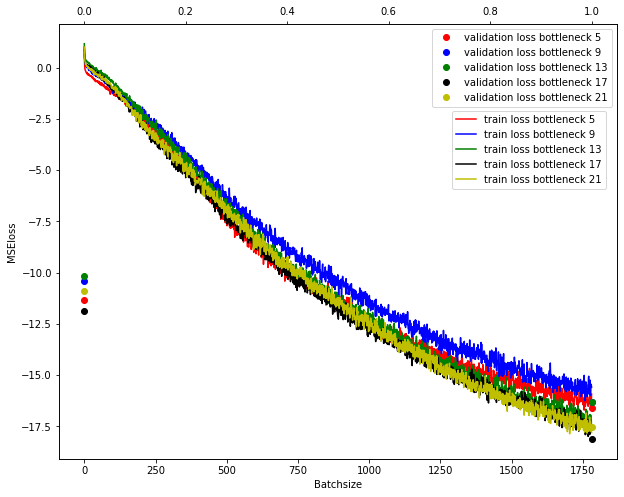

In [100]:
fig, ax1 = plt.subplots(figsize=(10,8))
plt.xlabel('Batchsize')
plt.ylabel('MSEloss')
form = ['-','o']
color = ['r','b','g','k','y']
ax2 = ax1.twiny()
i=0
for bottleneck in train_loss_bottleneck.keys():
  ax1.plot(train_loss_bottleneck.get(bottleneck),color[i]+form[0], label='train loss bottleneck {}'.format(bottleneck))
  
  ax2.plot(validation_loss_bottleneck.get(bottleneck),color[i]+form[1],label='validation loss bottleneck {}'.format(bottleneck))
  i+=1
ax1.legend(bbox_to_anchor=(0.98, 0.8), loc='upper right', borderaxespad=0.)
ax2.legend()
plt.show()

##Table of the differents MSE##

In [99]:
data = {"Bottleneck":["Test MSE","Validation MSE","number of parameters"]}
data.update(dic_MSE)
df = pd.DataFrame(data)
df = df.groupby('Bottleneck')
df.first()

,5,9,13,17,21
Bottleneck,,,,,
Test MSE,0.653558,0.655330,0.631896,0.578431,0.587001
Validation MSE,0.643902,0.646191,0.623162,0.569834,0.579055
number of parameters,471654.000000,475050.000000,478446.000000,481842.000000,485238.000000


We take the model for a bottleneck of size 17

In [0]:
bottleneck = 17
model = models[bottleneck]

Display of 5 random images and the ouput of the model

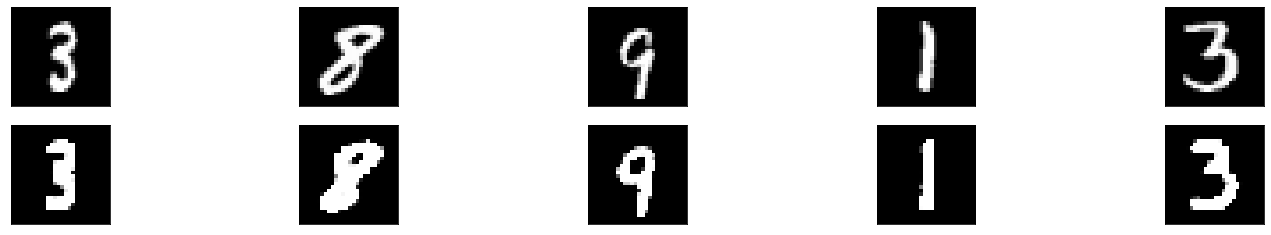

In [88]:
#take 5 random images
random_set_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=5, 
    shuffle=True)
dataiter = iter(random_set_loader)
images,_ =dataiter.next()
images = images.cuda()
output = model(images)
images = images.cpu().detach().numpy()
output = output.cpu().detach().numpy()
fig, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(25,4
))  
for images, row in zip([images, output],axes):
  for img,ax in zip(images,row):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

**Generate 5 new images**

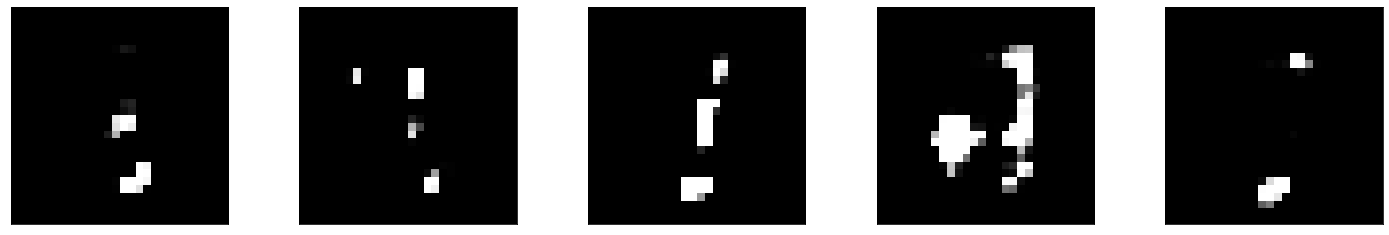

In [89]:
#for i in range(5):
nb_images = 5
rand_features = torch.randn(nb_images, bottleneck).to(hparams['device']) 
output = model.decoder(rand_features)
#Visualisation
output = output.cpu().detach().numpy()
images_width = 28
fig, axes = plt.subplots(nrows=1,ncols=5,sharex=True,sharey=True,figsize=(25,4))
decoded_images = output[:nb_images]  
for ax, img in zip(axes, decoded_images):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#Exercice 2#

We take a subset of 100 images and their associates label from the MNIST training data.

In [0]:
nb_images_subnet = 100
[trainset,_]=torch.utils.data.random_split(mnist_trainset,[nb_images_subnet,tvdataset_length-nb_images_subnet])
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

We first take the layers of the encoder part of the  model autoencoder. We take the one with a bottleneck of length 15.

In [137]:
encoder_pretrain = model.encoder 
encoder_pretrain.eval()
encoder_pretrain.to(hparams['device'])

Encoder(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten()
  )
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=17, bias=True)
    (1): ReLU()
  )
)

We create the classification model

In [0]:
bottleneck = 17
class Classification(nn.Module):
  def __init__(self,endoder):
    super().__init__()
    self.layers = endoder
    #fully connected layers
    self.fc = nn.Sequential(
        nn.Linear(bottleneck,10),
        nn.LogSoftmax(dim=1)
    )
  def forward(self,x):
    x = self.layers(x)
    x= self.fc(x)
    return x

Training with the previous weights. 

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss
def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            #test_loss += criterion(output, target,reduction='sum').item() # sum up batch loss   eduction='sum'
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    #test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
         acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [0]:
def epoch(model_,optimizer_):  
    tr_losses = []
    te_losses = []
    te_accs = []
    model_.to(hparams['device'])
    optimizer = optimizer_ 
    criterion = F.nll_loss
    for epoch in range(1, hparams['num_epochs'] + 50):
      print('Epoch {}'.format(epoch))
      tr_losses.append(train_epoch(train_loader, model_, optimizer, criterion, hparams))
      te_loss, te_acc = test_epoch(test_loader, model_, hparams)
      te_losses.append(te_loss)
      te_accs.append(te_acc)   
    return te_accs

In [142]:
model_classifier = Classification(encoder_pretrain)
optimzer_pretrain = optim.RMSprop(model_classifier.parameters(), lr=hparams['learning_rate'])
accs_pretrain=epoch(model_classifier,optimzer_pretrain)

Epoch 1
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 11.295638

Test set: Accuracy: 2404/10000 (24%)

Epoch 2
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 2.127764

Test set: Accuracy: 3733/10000 (37%)

Epoch 3
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.711403

Test set: Accuracy: 5019/10000 (50%)

Epoch 4
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.682743

Test set: Accuracy: 5696/10000 (57%)

Epoch 5
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.388746

Test set: Accuracy: 6242/10000 (62%)

Epoch 6
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.210197

Test set: Accuracy: 6595/10000 (66%)

Epoch 7
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 0.976488

Test set: Accuracy: 7208/10000 (72%)

Epoch 8
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.037449

Test set: Accuracy: 6826/10000 (68%)

Epoch 9
Train E

Fine-tunning with the same learning rate 

In [0]:
fine_tuning_features = model.encoder
fine_tuning_model= Classification(fine_tuning_features)
optimzer_fine_tuning = optim.SGD([
                {'params': fine_tuning_model.layers.parameters()},
                {'params': fine_tuning_model.fc.parameters(), 'lr':hparams['learning_rate'] }
            ], lr=1e-6, momentum=0.9)


Train the model fine tuning with the normal learning rate

In [144]:
acc_fine_tuning =epoch(fine_tuning_model,optimzer_fine_tuning)

Epoch 1
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 12.201880

Test set: Accuracy: 590/10000 (6%)

Epoch 2
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 10.663253

Test set: Accuracy: 1801/10000 (18%)

Epoch 3
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 6.600730

Test set: Accuracy: 3054/10000 (31%)

Epoch 4
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 6.360655

Test set: Accuracy: 3529/10000 (35%)

Epoch 5
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 4.871706

Test set: Accuracy: 3493/10000 (35%)

Epoch 6
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 4.107152

Test set: Accuracy: 4125/10000 (41%)

Epoch 7
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 3.055625

Test set: Accuracy: 5387/10000 (54%)

Epoch 8
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 3.268137

Test set: Accuracy: 6237/10000 (62%)

Epoch 9
Train Ep

Model Train from scratch

In [145]:
bottleneck = 17
networ_scratch = Classification(Encoder(17))
optimzer_scratch = optim.RMSprop(model_classifier.parameters(), lr=hparams['learning_rate'])
accs_scratch = epoch(network_scratch,optimzer_scratch)

Epoch 1
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.098724

Test set: Accuracy: 974/10000 (10%)

Epoch 2
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.098795

Test set: Accuracy: 974/10000 (10%)

Epoch 3
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.101008

Test set: Accuracy: 974/10000 (10%)

Epoch 4
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.097297

Test set: Accuracy: 974/10000 (10%)

Epoch 5
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.100301

Test set: Accuracy: 974/10000 (10%)

Epoch 6
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.100569

Test set: Accuracy: 974/10000 (10%)

Epoch 7
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.098615

Test set: Accuracy: 974/10000 (10%)

Epoch 8
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.099151

Test set: Accuracy: 974/10000 (10%)

Epoch 9
Train Ep

Train the model from scratch

Plot all the accuracy

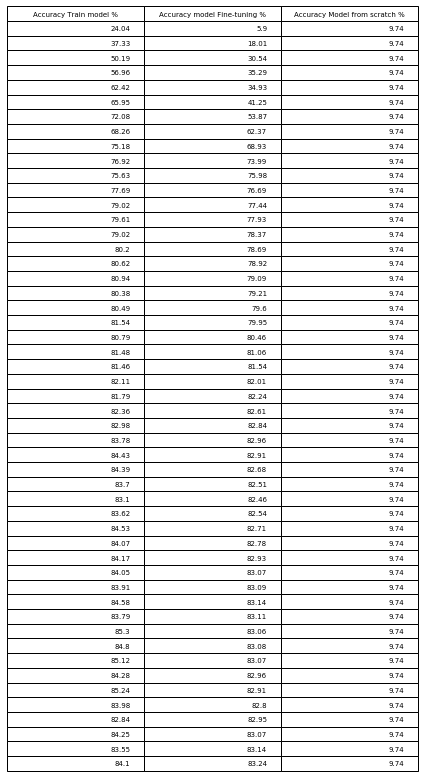

In [146]:
fig, ax = plt.subplots()
#hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
data = {'Accuracy Train model %':accs_pretrain,'Accuracy model Fine-tuning %':acc_fine_tuning,'Accuracy Model from scratch %':accs_scratch}
df = pd.DataFrame(data)
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
fig.tight_layout()
plt.show()